In [2]:
import matplotlib 
import matplotlib.pyplot as plt 
import pandas_datareader as dt
import io, base64, os, json, re , math
import pandas as pd 
import numpy as np
import datetime
import warnings
import calendar
import statsmodels.api as sm
import datetime
from dateutil import relativedelta

import calendar, os, io, base64
from dateutil import relativedelta



%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
pwd

'C:\\Users\\A\\Documents\\Publishables and interview\\SP500 Forecaster'

## Clean the data

- Clean the data and add more features to help the model. 


- By cleaning up the missing values we will help our model train without any problems 

In [4]:
#load the cli data
cci_raw=pd.read_csv('https://stats.oecd.org/sdmx-json/data/DP_LIVE/OECD.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
cci_df=cci_raw[cci_raw['LOCATION'] =='OECD']
    
full_date_list=[]
for tm in cci_df['TIME']:
    year=int(tm.split('-')[0])
    month=int(tm.split('-')[1])
    #print calendar full date
    full_date_list.append(tm + '-'+str(calendar.monthrange(year,month)[1]))
        
cci_df['Date'] = full_date_list
cci_df['Date']= pd.to_datetime(cci_df['Date'])
cci_df=cci_df[['Date','Value']]
cci_df.index=cci_df['Date']


In [5]:
cci_df_full=cci_df[['Date','Value']]
cci_df_full = cci_df_full.set_index('Date')
cci_df_full

,Value
Date,
1974-01-31,99.0358
1974-02-28,99.0098
1974-03-31,99.1399
1974-04-30,99.2691
1974-05-31,99.2506
...,...
2019-12-31,100.5569
2020-01-31,100.5444
2020-02-29,100.1781


In [6]:
prediction_months=12

#Make a prediction column by shifting the values up by 12 months
cci_df['Prediction']=cci_df[['Value']].shift(-prediction_months)

#make several rollingMA to help the model learn better
cci_df['7_months MA']=cci_df['Value'].rolling(window=7).mean()
cci_df['4_months MA']=cci_df['Value'].rolling(window=4).mean()
cci_df['2_months MA']=cci_df['Value'].rolling(window=2).mean()



#drop the NaN values
cci_cleaned=cci_df.dropna(subset=['7_months MA','4_months MA','2_months MA', 'Prediction'])

#cci_cleaned2=cci_svm.dropna(subset=['Prediction'])

#Get rid of the NAN values
cci_cleaned.reset_index(drop=True, inplace=True)

del cci_cleaned['Date']


cci_cleaned.tail(20)


,Value,Prediction,7_months MA,4_months MA,2_months MA
518,100.7783,100.7647,100.628529,100.697375,100.74880
519,100.8542,100.6774,100.684771,100.753525,100.81625
520,100.8717,100.5765,100.731557,100.805875,100.86295
521,100.8634,100.4858,100.768400,100.841900,100.86755
522,100.8795,100.4264,100.804100,100.867200,100.87145
523,100.9161,100.4771,100.840357,100.882675,100.89780
524,100.9271,100.5566,100.870043,100.896525,100.92160
525,100.8972,100.5814,100.887029,100.904975,100.91215
526,100.8713,100.5523,100.889471,100.902925,100.88425
527,100.8655,100.4645,100.888586,100.890275,100.86840


- As we have dropped all the NaN values from the cleaned dataset, we have essentially got rid of the last 12months values(mainly due to deleting the NaN values from the predictioin column)

# Future Data (last 12 months)

- We will be feeding in the future_x_inputs which are the features label of the last 12months of the cleaned dataset



- The goal is to pass these last values to the model at the end and assess how close we were to the actual current last 12 months data 


In [7]:
future_x_inputs=cci_cleaned.copy()

#drop the 'Prediction' column as that is the y label
del future_x_inputs['Prediction']

#Normalize the future x inputs and put in array
future_x_inputs=np.log(future_x_inputs)
future_x_inputs=future_x_inputs.to_numpy()

#Bare in mind this does not include the very last 12 months x_feature values 
# of the cci but the 12 values before it

#We are only interested in the last 12 month values from the cleaned data
future_x_inputs=future_x_inputs[-12:]
#future_x_inputs=np.delete(future_x_inputs,1)
future_x_inputs



array([[4.61384545, 4.61402558, 4.61415892, 4.61397382],
       [4.61378795, 4.6140168 , 4.61403354, 4.6138167 ],
       [4.61384842, 4.61402841, 4.61389601, 4.61381818],
       [4.61340419, 4.61395378, 4.61372152, 4.61362633],
       [4.6127881 , 4.61373937, 4.61345725, 4.61309619],
       [4.61192135, 4.61338563, 4.61299078, 4.61235481],
       [4.61091863, 4.61293113, 4.6122585 , 4.61142011],
       [4.61001642, 4.61238453, 4.61141167, 4.61046763],
       [4.60942512, 4.61176156, 4.61057083, 4.60972082],
       [4.60992984, 4.61120153, 4.61007265, 4.60967751],
       [4.61072075, 4.61081778, 4.61002314, 4.61032538],
       [4.61096735, 4.61055736, 4.61026096, 4.61084406]])

##### The actual very last datapoints

In [8]:
#The actual values of actual current last 12 months values
#These values are not in the CCI cleaned datase therefore the model hasnt seen
all_cci_data=cci_df[['Value']]
all_cci_data.reset_index(drop=True, inplace=True)
actual_last_12months= np.log(all_cci_data)
actual_last_12months=actual_last_12months.to_numpy()
actual_last_12months=actual_last_12months[-12:]
actual_last_12months

array([[4.61067799],
       [4.60980443],
       [4.60857737],
       [4.60717917],
       [4.60703245],
       [4.60788949],
       [4.60944504],
       [4.61072374],
       [4.61059942],
       [4.6069496 ],
       [4.59747566],
       [4.58314541]])

- The Goal here is to take future_x_inputs and pass it to the trained model in order to get the forcasted 12 month CCI values. We will the take these values and compare it to the actual_last_12months in order to see how close our model was to the real values.

# Preparing the data for model 

## Normalize the data

- By normalizing the data we are essentiallty squashing all the vlues together whilst considering the incremental difference between values. 


- This helps the model train better as the dataset values are no longer very sparse


- We have chosen to use log function to do this as it is very easy to use when reverting back to the real actual values once we get the forecasted values

In [9]:
#Get the all the neccessary column values
values=cci_cleaned[['Value','7_months MA','4_months MA','2_months MA','Prediction']]

#change values to log form
values=np.log(values)

#change format to numpy array
values=values.to_numpy()
values



array([[4.59412339, 4.59614458, 4.59644473, 4.59514662, 4.60140611],
       [4.59214371, 4.59566876, 4.59502313, 4.59313404, 4.60177443],
       [4.59038035, 4.59497929, 4.5932064 , 4.59126242, 4.60224692],
       ...,
       [4.60992984, 4.61120153, 4.61007265, 4.60967751, 4.6069496 ],
       [4.61072075, 4.61081778, 4.61002314, 4.61032538, 4.59747566],
       [4.61096735, 4.61055736, 4.61026096, 4.61084406, 4.58314541]])

# Xlabel

- This will hold all our feature columns which are: 
- [Value], [7_months MA], [4_months MA], [2_months MA]

In [10]:
X=values[:,0:4]
X

array([[4.59412339, 4.59614458, 4.59644473, 4.59514662],
       [4.59214371, 4.59566876, 4.59502313, 4.59313404],
       [4.59038035, 4.59497929, 4.5932064 , 4.59126242],
       ...,
       [4.60992984, 4.61120153, 4.61007265, 4.60967751],
       [4.61072075, 4.61081778, 4.61002314, 4.61032538],
       [4.61096735, 4.61055736, 4.61026096, 4.61084406]])

# ylabel

- This will hold the prediction value, which is the column which is shifted up by 12 rows

In [11]:
y=values[:,4:5]
y


array([[4.60140611],
       [4.60177443],
       [4.60224692],
       [4.60344871],
       [4.60580399],
       [4.60878764],
       [4.61139477],
       [4.61267793],
       [4.61310859],
       [4.61341709],
       [4.61402388],
       [4.61458869],
       [4.61469468],
       [4.61412695],
       [4.61324152],
       [4.61252209],
       [4.61243771],
       [4.61282481],
       [4.6133794 ],
       [4.61367194],
       [4.61354502],
       [4.61311851],
       [4.61284268],
       [4.61316117],
       [4.61381868],
       [4.61437172],
       [4.61484424],
       [4.61535316],
       [4.61584204],
       [4.6163109 ],
       [4.61656205],
       [4.6163376 ],
       [4.61570945],
       [4.61567284],
       [4.61588953],
       [4.61589942],
       [4.61598846],
       [4.6157896 ],
       [4.61565503],
       [4.6145768 ],
       [4.61235432],
       [4.61010698],
       [4.60949183],
       [4.60932554],
       [4.60855944],
       [4.60762816],
       [4.60660416],
       [4.604

# Training and Testing 

In [12]:
#splt the data to 80 learning 20 test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [13]:
#import the neccessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
model=Sequential()
model.add(Dense(200, input_dim=X.shape[1], activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=0)

history=model.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)

Train on 360 samples, validate on 178 samples
Epoch 1/250
360/360 [==============================] - 0s 1ms/sample - loss: 5.4335 - val_loss: 1.5852
Epoch 2/250
360/360 [==============================] - 0s 108us/sample - loss: 0.8196 - val_loss: 0.1152
Epoch 3/250
360/360 [==============================] - 0s 106us/sample - loss: 0.2245 - val_loss: 0.0137
Epoch 4/250
360/360 [==============================] - 0s 125us/sample - loss: 0.0402 - val_loss: 0.0235
Epoch 5/250
360/360 [==============================] - 0s 525us/sample - loss: 0.0108 - val_loss: 0.0124
Epoch 6/250
360/360 [==============================] - 0s 186us/sample - loss: 0.0039 - val_loss: 0.0041
Epoch 7/250
360/360 [==============================] - 0s 108us/sample - loss: 0.0014 - val_loss: 0.0013
Epoch 8/250
360/360 [==============================] - 0s 119us/sample - loss: 4.6201e-04 - val_loss: 3.7480e-04
Epoch 9/250
360/360 [==============================] - 0s 111us/sample - loss: 1.7085e-04 - val_loss: 1.7764

In [21]:
#Th model loss and validation loss during training

model_loss=history.history['loss']
model_val_loss=history.history['val_loss']



### Check for over/under fitting

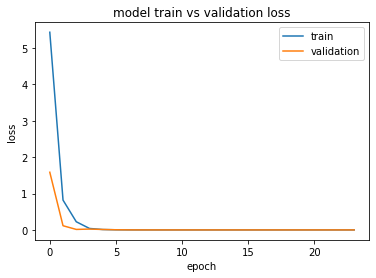

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()



- We can see that the model is not overfitting or underfitiing for this case as the loss and validation loss have fully coverged.



### Accuracy score

In [23]:
#Find the model accuracy using the X_test and y_test
from sklearn import metrics

#predict the y values by passing the X_test to the model
pred= model.predict(X_test)

#Asses the difference between the models prediction vs the actual values(y_test)
score= np.sqrt(metrics.mean_squared_error(pred, y_test))
print('Final score (RMSE): {}'.format(np.exp(score)))


Final score (RMSE): 1.0077696222590802


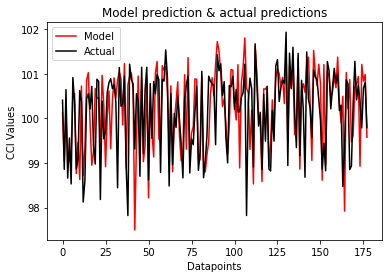

In [24]:
#plot the model output and actual y values 
#use np.exp to convert the log numbers to real readable data
plt.plot(np.exp(model.predict(X_test)), color='red')
plt.plot(np.exp(y_test),color='black')

plt.title('Model prediction & actual predictions')
plt.ylabel('CCI Values')
plt.xlabel('Datapoints')
plt.legend(['Model', 'Actual'], loc='best')

#### Further model assessment 

- Using the last 12 Xlabel rows as inputs to the model , we will get the the models predicted y_values. We then will compare those values with the current last 12 months of data and asses how close they were to real value.

In [25]:
#prediction of the y value for the last 12 rows of cleaned_dataset
pred2= model.predict(future_x_inputs)

#Compare the pred with actual values
score= np.sqrt(metrics.mean_squared_error(pred2, actual_last_12months))
print('Final score (RMSE): {}'.format(np.exp(score)))


Final score (RMSE): 1.010549398745319


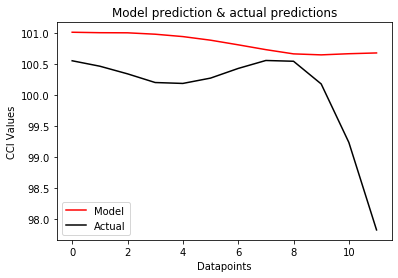

In [26]:
#plot the model output and actual y values for last 12 months
#use np.exp to convert the log numbers to real readable data
plt.plot(np.exp(pred2), color='red')
plt.plot(np.exp(actual_last_12months),color='black')

plt.title('Model prediction & actual predictions')
plt.ylabel('CCI Values')
plt.xlabel('Datapoints')
plt.legend(['Model', 'Actual'], loc='best')

- We can see the model has not done the best job.

# Future Forecast 

#### Prepare the feature input data to the model

In [27]:
cci_df_full2=cci_df_full.copy()

#make several rollingMA to help the model learn better
cci_df_full2['7_months MA']=cci_df_full2['Value'].rolling(window=7).mean()
cci_df_full2['4_months MA']=cci_df_full2['Value'].rolling(window=4).mean()
cci_df_full2['2_months MA']=cci_df_full2['Value'].rolling(window=2).mean()

#drop the NaN values in all columns
cci_df_full2=cci_df_full2.dropna(subset=['7_months MA','4_months MA','2_months MA'])

#Reset the index column and delete the date columns
cci_df_full2.reset_index(drop=True, inplace=True)
#del cci_df_full2['Date']

#change values to log form
cci_df_full2=np.log(cci_df_full2)
#change format to numpy array
cci_df_full2=cci_df_full2.to_numpy()
#Get only the last 12 months datapoints
cci_df_full2=cci_df_full2[-12:]
cci_df_full2


array([[4.61067799, 4.61037959, 4.61057406, 4.61082268],
       [4.60980443, 4.61022041, 4.61054273, 4.61024131],
       [4.60857737, 4.610015  , 4.61000722, 4.60919109],
       [4.60717917, 4.60969465, 4.60906061, 4.60787852],
       [4.60703245, 4.60928115, 4.60814899, 4.60710581],
       [4.60788949, 4.60887659, 4.60766981, 4.60746106],
       [4.60944504, 4.60865881, 4.60788699, 4.60866756],
       [4.61072374, 4.60866536, 4.60877369, 4.61008459],
       [4.61059942, 4.60877909, 4.60966507, 4.61066158],
       [4.6069496 , 4.60854676, 4.6094306 , 4.60877618],
       [4.59747566, 4.60716819, 4.60645161, 4.60222385],
       [4.58314541, 4.60379095, 4.59959869, 4.5903362 ]])

### Actual Prediction

In [57]:
upcoming_forecast= model.predict(cci_df_full2)
upcoming_forecast

array([[4.6118813],
       [4.611501 ],
       [4.6108065],
       [4.6098824],
       [4.609372 ],
       [4.6094155],
       [4.610012 ],
       [4.6108055],
       [4.6111197],
       [4.6096926],
       [4.6049004],
       [4.596394 ]], dtype=float32)

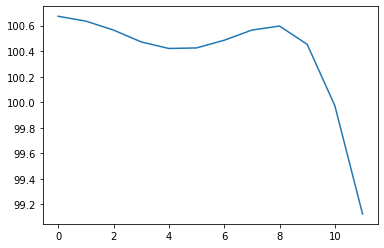

In [29]:
plt.plot(np.exp(upcoming_forecast))

# Plot Everything together 

In [30]:
forwarded_dates=[]
year=2020
for i in range(5,13):
    forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
    


In [31]:
year=2021
for i in range(1,12):
    forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
    


In [32]:
forwarded_dates

['2020-5-31',
 '2020-6-30',
 '2020-7-31',
 '2020-8-31',
 '2020-9-30',
 '2020-10-31',
 '2020-11-30',
 '2020-12-31',
 '2021-1-31',
 '2021-2-28',
 '2021-3-31',
 '2021-4-30',
 '2021-5-31',
 '2021-6-30',
 '2021-7-31',
 '2021-8-31',
 '2021-9-30',
 '2021-10-31',
 '2021-11-30']

In [54]:
#append forecasted dates to dataframe
df_forecast=pd.DataFrame(forwarded_dates)
df_forecast.columns=['Date']

upcoming_f=np.exp(upcoming_forecast)
upcoming_f=pd.DataFrame(upcoming_f)

df_forecast['Value']=upcoming_f
#set column as datetime
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
#set index as date
df_forecast = df_forecast.set_index('Date')

df_forecast

,Value
Date,
2020-05-31,100.673363
2020-06-30,100.635109
2020-07-31,100.565216
2020-08-31,100.472328
2020-09-30,100.421082
2020-10-31,100.425438
2020-11-30,100.485359
2020-12-31,100.565125
2021-01-31,100.596733


In [38]:
last_date=cci_df_full.tail(1)
df_forecast=df_forecast.append(last_date)
df_forecast=df_forecast.drop_duplicates()
df_forecast = df_forecast.sort_index()
df_forecast

,Value
Date,
2020-04-30,97.821600
2020-05-31,100.673363
2020-06-30,100.635109
2020-07-31,100.565216
2020-08-31,100.472328
2020-09-30,100.421082
2020-10-31,100.425438
2020-11-30,100.485359
2020-12-31,100.565125


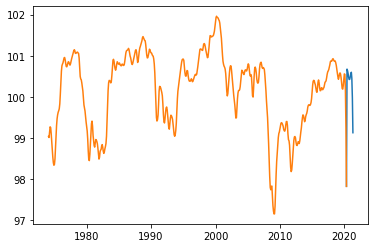

In [39]:
plt.plot(df_forecast)
plt.plot(cci_df_full)

# Putting everything together

In [50]:
history_cci=None
cci_df=None

def Startup():
    
    global history,cci_df,model
    
    #load the cli data
    cci_raw=pd.read_csv('https://stats.oecd.org/sdmx-json/data/DP_LIVE/OECD.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en')
    cci_df=cci_raw[cci_raw['LOCATION'] =='OECD']

    full_date_list=[]
    for tm in cci_df['TIME']:
        year=int(tm.split('-')[0])
        month=int(tm.split('-')[1])
        #print calendar full date
        full_date_list.append(tm + '-'+str(calendar.monthrange(year,month)[1]))

    cci_df['Date'] = full_date_list
    cci_df['Date']= pd.to_datetime(cci_df['Date'])
    cci_df=cci_df[['Date','Value']]
    cci_df.index=cci_df['Date']
    
    cci_df_full=cci_df[['Date','Value']]
    cci_df_full = cci_df_full.set_index('Date')
    
    #Added learning columns
    
    prediction_months=12

    #Make a prediction column by shifting the values up by 12 months
    cci_df['Prediction']=cci_df[['Value']].shift(-prediction_months)

    #make several rollingMA to help the model learn better
    cci_df['7_months MA']=cci_df['Value'].rolling(window=7).mean()
    cci_df['4_months MA']=cci_df['Value'].rolling(window=4).mean()
    cci_df['2_months MA']=cci_df['Value'].rolling(window=2).mean()



    #drop the NaN values
    cci_cleaned=cci_df.dropna(subset=['7_months MA','4_months MA','2_months MA', 'Prediction'])

    #cci_cleaned2=cci_svm.dropna(subset=['Prediction'])

    #Get rid of the NAN values
    cci_cleaned.reset_index(drop=True, inplace=True)
    del cci_cleaned['Date']
    
    
    
    
    future_x_inputs=cci_cleaned.copy()

    #drop the 'Prediction' column as that is the y label
    del future_x_inputs['Prediction']

    #Normalize the future x inputs and put in array
    future_x_inputs=np.log(future_x_inputs)
    future_x_inputs=future_x_inputs.to_numpy()

    #Bare in mind this does not include the very last 12 months x_feature values 
    # of the cci but the 12 values before it

    #We are only interested in the last 12 month values from the cleaned data
    future_x_inputs=future_x_inputs[-12:]
    #future_x_inputs=np.delete(future_x_inputs,1)
    
    

        #The actual values of actual current last 12 months values
    #These values are not in the CCI cleaned datase therefore the model hasnt seen
    all_cci_data=cci_df[['Value']]
    all_cci_data.reset_index(drop=True, inplace=True)
    actual_last_12months= np.log(all_cci_data)
    actual_last_12months=actual_last_12months.to_numpy()
    actual_last_12months=actual_last_12months[-12:]
    
    
    
    #Get the all the neccessary column values
    values=cci_cleaned[['Value','7_months MA','4_months MA','2_months MA','Prediction']]

    #change values to log form
    values=np.log(values)

    #change format to numpy array
    values=values.to_numpy()
    
    
    X=values[:,0:4]
    y=values[:,4:5]
    
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
    
    model=Sequential()
    model.add(Dense(200, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, verbose=0)

    history_cci=model.fit(X_train,y_train,validation_data=(X_test,y_test), callbacks=[monitor],epochs=250)
    
    
def GetForecast(months_out3):
    
    
    
    forwarded_dates=[]
    year=2020
    for i in range(5,13):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
    year=2021
    for i in range(1,5):
        forwarded_dates.append(str(year)+'-'+str(i)+'-'+str(calendar.monthrange(year,i)[1]))
        
        
    #append forecasted dates to dataframe
    df_forecast=pd.DataFrame(forwarded_dates)
    df_forecast.columns=['Date']

    upcoming_f=np.exp(upcoming_forecast)
    upcoming_f=pd.DataFrame(upcoming_f)

    df_forecast['Value']=upcoming_f
    #set column as datetime
    df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
    #set index as date
    df_forecast = df_forecast.set_index('Date')
    
    last_date=cci_df_full.tail(1)
    df_forecast=df_forecast.append(last_date)
    df_forecast=df_forecast.drop_duplicates()
    df_forecast = df_forecast.sort_index()
    
    fig,ax=plt.subplots(figsize=(16,10))
    plt.plot(df_forecast.head(months_out3+1), label='Neural Net model')
    plt.plot(cci_df_full, label='Actual')
    
    ax.axhline(y=100,color='gray')
    plt.legend(loc='best')
    plt.title('CCI Forecast Util ')
    plt.show()


    
    
    

In [51]:
Startup()

Train on 360 samples, validate on 178 samples
Epoch 1/250
360/360 [==============================] - 1s 1ms/sample - loss: 2.5164 - val_loss: 0.6090
Epoch 2/250
360/360 [==============================] - 0s 114us/sample - loss: 0.2912 - val_loss: 0.2159
Epoch 3/250
360/360 [==============================] - 0s 122us/sample - loss: 0.0874 - val_loss: 0.0639
Epoch 4/250
360/360 [==============================] - 0s 108us/sample - loss: 0.0267 - val_loss: 0.0158
Epoch 5/250
360/360 [==============================] - 0s 125us/sample - loss: 0.0080 - val_loss: 0.0019
Epoch 6/250
360/360 [==============================] - 0s 111us/sample - loss: 0.0024 - val_loss: 5.9805e-05
Epoch 7/250
360/360 [==============================] - 0s 111us/sample - loss: 7.5061e-04 - val_loss: 3.5388e-04
Epoch 8/250
360/360 [==============================] - 0s 108us/sample - loss: 3.2700e-04 - val_loss: 2.5304e-04
Epoch 9/250
360/360 [==============================] - 0s 103us/sample - loss: 1.5667e-04 - val_

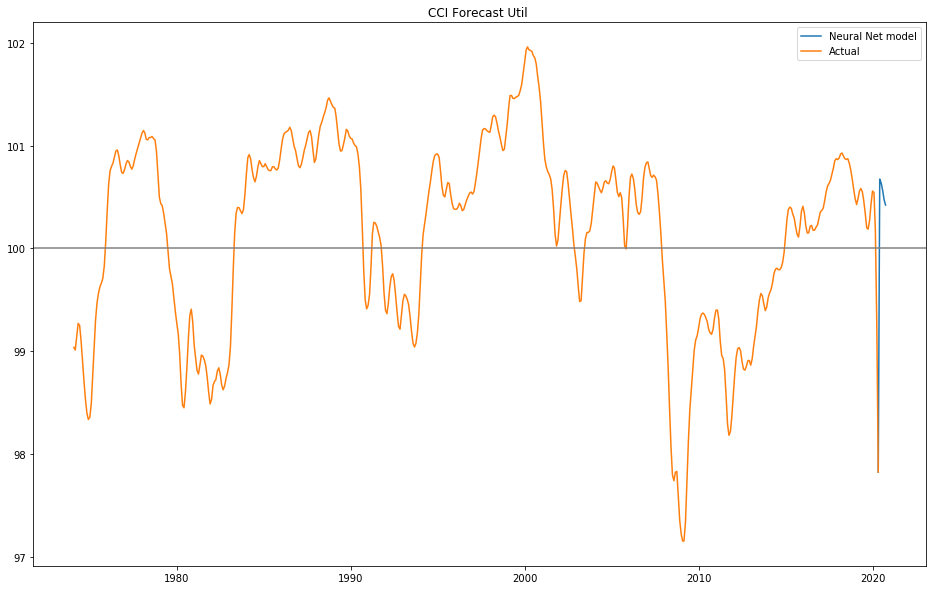

In [52]:
GetForecast(5)